In [6]:
# | output: false
# Setup Notebook

path = "../../../../scripts/notebook_header.py"
import os


if os.path.basename(os.getcwd()) != "mtg-modeling":
    args = f"--path {path}"
    get_ipython().run_line_magic("run", f"-i {path} {args}")  # type: ignore

In [7]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

import src.plots.annotate as anno
import src.plots.symbols as symbols

In [8]:
set_code = "All_Sets"
set_codes_order = ["MKM", "OTJ", "MH3", "BLB"]

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{set_code}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{set_code}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{set_code}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{set_code}_Game_PD_Cards.parquet"

In [9]:
df_draft = pl.scan_parquet(draft_file)

# Builds

A player can rebuild their deck between games by utilizing their sideboard during a draft session. I wanted to explore how often players rebuild their decks and whether this impacts win rate. This analysis focuses on premier draft, a best-of-one format, where there is less incentive to rebuild a deck compared to a best-of-three format.

In @fig-n-games-rebuilds, we see that over 75% of draft sessions use the same deck build throughout. Only a tiny fraction of sessions feature more than two different builds.

In [10]:
builds = (
    df_draft.group_by(["n_builds", "expansion"])
    .agg(
        pl.col("n_wins").sum().alias("n_wins"),
        pl.col("n_games").sum().alias("n_games"),
    )
    .with_columns(
        (pl.col("n_wins") / pl.col("n_games")).alias("win_rate"),
        (pl.col("n_games") / pl.col("n_games").sum()).alias("pct_games"),
    )
    .sort(by=["expansion", "n_builds"], descending=True)
)

mean_win_rate = (
    builds.group_by("expansion")
    .agg(
        pl.col("n_games").sum().alias("set_n_games"),
        pl.col("n_wins").sum().alias("set_n_wins"),
    )
    .select(
        "expansion",
        "set_n_games",
        (pl.col("set_n_wins") / pl.col("set_n_games")).alias("set_win_rate"),
    )
)

builds = (
    builds.join(mean_win_rate, on="expansion")
    .with_columns(
        (pl.col("win_rate") / pl.col("set_win_rate")).alias("normalized_win_rate"),
        (pl.col("n_games") / pl.col("set_n_games")).alias("normalized_pct_games"),
    )
    .collect()
    .to_pandas()
)

builds = builds.loc[builds["n_builds"] <= 4]

FileNotFoundError: No such file or directory (os error 2): data/processed/17lands/game_data/premier_draft/All_Sets_Game_PD_Drafts.parquet

This error occurred with the following context stack:
	[1] 'parquet scan' failed
	[2] 'group_by' input failed to resolve
	[3] 'with_columns' input failed to resolve
	[4] 'sort' input failed to resolve
	[5] 'join left' input failed to resolve
	[6] 'with_columns' input failed to resolve


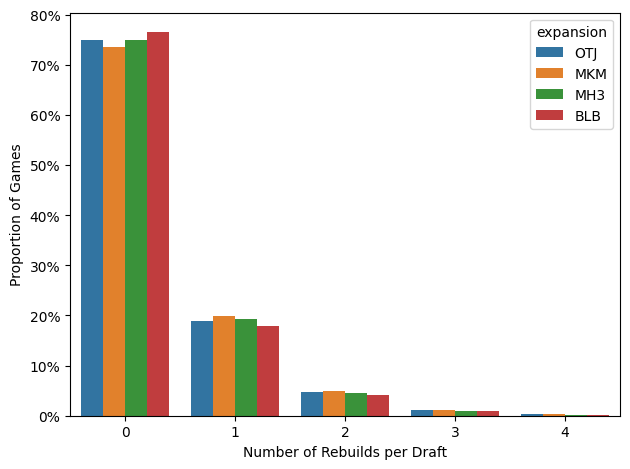

In [6]:
# | label: fig-n-games-rebuilds
# | fig-cap: "The proportion of games for the number of rebuilds."

builds
sns.barplot(data=builds, x="n_builds", y="normalized_pct_games", hue="expansion")
anno.set_labels_to_percent(axis="y")
anno.set_axis_labels_and_show(
    xlabel="Number of Rebuilds per Draft",
    ylabel="Proportion of Games",
)

In @fig-rebuilds-wins, we observe the relationship between win rate and the number of rebuilds. Decks with more rebuilds tend to have lower win rates, but it's unclear whether players are rebuilding more to salvage a poorly drafted deck or if rebuilding itself is a suboptimal strategy.

In [7]:
filtered_builds = builds.loc[builds["n_builds"] <= 3]

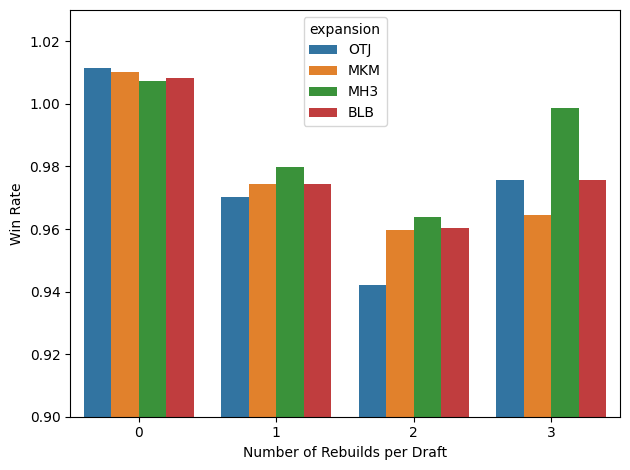

In [8]:
# | label: fig-rebuilds-wins
# | fig-cap: "The win rate for a number of deck rebuilds."

sns.barplot(
    data=filtered_builds, x="n_builds", y="normalized_win_rate", hue="expansion"
)
plt.gca().set_ylim([0.9, 1.03])
# anno.set_labels_to_percent(axis="y")
anno.set_axis_labels_and_show(
    xlabel="Number of Rebuilds per Draft",
    ylabel="Win Rate",
)